In [2]:
import pandas as pd
from pandas import read_csv
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

os.chdir('/Volumes/GoogleDrive/My Drive/BEAM-CORE/BEAM Validation')

plt.style.use('ggplot')

In [3]:
# load data for validation
modeled_vmt = read_csv('sample output/AUS2018/0.linkstats.csv.gz', low_memory=False)
observed_vmt = read_csv('data for validation/Austin/VMT/austin_roadway_inventory.csv', low_memory=False)
model_network = read_csv('sample output/AUS2018/beam_network_by_county.csv', low_memory=False)
modeled_vmt.head(5)

,link,from,to,hour,length,freespeed,capacity,stat,volume,traveltime
0,285550,102109,120927,0.0,13.623,14.75232,2100.0,AVG,0.0,0.923448
1,285550,102109,120927,1.0,13.623,14.75232,2100.0,AVG,0.0,0.923448
2,285550,102109,120927,2.0,13.623,14.75232,2100.0,AVG,0.0,0.923448
3,285550,102109,120927,3.0,13.623,14.75232,2100.0,AVG,0.0,0.923448
4,285550,102109,120927,4.0,13.623,14.75232,2100.0,AVG,0.0,0.923448


In [14]:
total_lane_mile_observed = observed_vmt['LN_MILES'].sum()
print(total_lane_mile_observed)
observed_vmt.head(5)

31169.408


,CO,REC,HSUF,DIR_TRAV,STE_NAM,DI,CITY,MPA,RU,ADMIN,...,ADT_ADJ,TRK_AADT_P,AADT_TRUCK,LEN_SEC,LN_MILES,DVMT,DTRKVMT,County.Name,TxDOT..District.Name,PVMT
0,11,0,NaN,4,NaN,14,39650,90,1,1,...,227,0.0,0,0.282,0.282,64.014,0.000,Bastrop,Austin,64.014
1,11,0,NaN,4,NaN,14,39650,90,1,1,...,3363,0.0,0,0.280,0.280,941.640,0.000,Bastrop,Austin,941.640
2,11,0,NaN,4,NaN,14,39650,90,1,1,...,591,0.0,0,0.339,0.339,200.349,0.000,Bastrop,Austin,200.349
3,11,5,NaN,3,MT. PLEASANT RD,14,0,90,1,2,...,115,3.2,4,0.569,1.138,65.435,2.276,Bastrop,Austin,63.159
4,11,5,NaN,3,OLD MCDADE RD,14,0,90,1,2,...,226,3.2,7,0.277,0.554,62.602,1.939,Bastrop,Austin,60.663


In [5]:
meter_to_mile = 0.000621371
model_network = model_network.drop_duplicates(subset=['linkId'])
model_network.head(5)
model_network.loc[:, 'lane_mile'] = meter_to_mile * model_network.loc[:, 'linkLength'] * model_network.loc[:, 'numberOfLanes']
total_lane_mile_modeled = model_network['lane_mile'].sum()
print(total_lane_mile_modeled)

46312.51890791604


In [6]:
# filter modeled network
model_vmt_24_hour = modeled_vmt.loc[(modeled_vmt['hour'] <= 28) & (modeled_vmt['hour'] >= 5)]
model_network['fromNodeId'] = model_network['fromNodeId'].astype(int)
model_network['toNodeId'] = model_network['toNodeId'].astype(int)
model_vmt_24_hour = pd.merge(modeled_vmt, model_network, 
                                 left_on = ['link', 'from', 'to'],
                                 right_on = ['linkId', 'fromNodeId', 'toNodeId'], how = 'left')
model_vmt_24_hour.head(5)

,link,from,to,hour,length_x,freespeed,capacity,stat,volume,traveltime,...,numberOfLanes,linkModes,attributeOrigId,attributeOrigType,fromNodeId,toNodeId,name,txdot_abbr,fips_code,lane_mile
0,285550,102109,120927,0.0,13.623,14.75232,2100.0,AVG,0.0,0.923448,...,1.0,car;walk;bike,544896591.0,tertiary,102109.0,120927.0,Williamson,14.0,491.0,0.008465
1,285550,102109,120927,1.0,13.623,14.75232,2100.0,AVG,0.0,0.923448,...,1.0,car;walk;bike,544896591.0,tertiary,102109.0,120927.0,Williamson,14.0,491.0,0.008465
2,285550,102109,120927,2.0,13.623,14.75232,2100.0,AVG,0.0,0.923448,...,1.0,car;walk;bike,544896591.0,tertiary,102109.0,120927.0,Williamson,14.0,491.0,0.008465
3,285550,102109,120927,3.0,13.623,14.75232,2100.0,AVG,0.0,0.923448,...,1.0,car;walk;bike,544896591.0,tertiary,102109.0,120927.0,Williamson,14.0,491.0,0.008465
4,285550,102109,120927,4.0,13.623,14.75232,2100.0,AVG,0.0,0.923448,...,1.0,car;walk;bike,544896591.0,tertiary,102109.0,120927.0,Williamson,14.0,491.0,0.008465


In [7]:
model_vmt_24_hour.loc[:, 'lane_mile'] = meter_to_mile * model_vmt_24_hour.loc[:, 'numberOfLanes'] * model_vmt_24_hour.loc[:, 'linkLength'] / 60.0
total_lane_mile_with_cars = model_vmt_24_hour.loc[:, 'lane_mile'].sum()
print(total_lane_mile_with_cars)

46312.518907916


In [8]:
model_vmt_24_hour = model_vmt_24_hour.rename(columns = {'length_x': 'length_raw', 
                                                        'length_y': 'length_adj'})
print(model_vmt_24_hour.columns)

Index(['link', 'from', 'to', 'hour', 'length_raw', 'freespeed', 'capacity',
       'stat', 'volume', 'traveltime', 'Unnamed: 0', 'linkId', 'linkLength',
       'length_adj', 'linkFreeSpeed', 'linkCapacity', 'numberOfLanes',
       'linkModes', 'attributeOrigId', 'attributeOrigType', 'fromNodeId',
       'toNodeId', 'name', 'txdot_abbr', 'fips_code', 'lane_mile'],
      dtype='object')


In [9]:
percent_of_samples = 0.2
demand_scaling = 1/percent_of_samples
model_vmt_24_hour.loc[:, 'VMT'] = demand_scaling * meter_to_mile * model_vmt_24_hour.loc[:, 'linkLength'] * model_vmt_24_hour.loc[:, 'volume']
model_vmt_by_county = model_vmt_24_hour.groupby(['name'])[['VMT']].sum()
model_vmt_by_county = model_vmt_by_county.reset_index()
model_vmt_by_county


,name,VMT
0,Bastrop,1.945346e+06
1,Burnet,2.234923e+06
2,Caldwell,9.657520e+05
3,Hays,3.399911e+06
4,Travis,2.526090e+07
5,Williamson,8.731701e+06


['car;walk;bike' 'walk;bike' 'car;bike' 'bike' nan]


In [10]:
observed_vmt.loc[:, 'PVMT'] = observed_vmt.loc[:, 'DVMT'] - observed_vmt.loc[:, 'DTRKVMT']
observed_vmt_by_county = observed_vmt.groupby('County.Name')[['PVMT']].sum()
observed_vmt_by_county = observed_vmt_by_county.reset_index()
observed_vmt_by_county

,County.Name,PVMT
0,Bastrop,4.794145e+06
1,Burnet,1.755911e+06
2,Caldwell,1.827492e+06
3,Hays,1.071075e+07
4,Travis,5.805417e+07
5,Williamson,2.173452e+07


In [11]:
VMT_comparison = pd.merge(model_vmt_by_county, observed_vmt_by_county, 
                          left_on = 'name', right_on = 'County.Name', how = 'left')
VMT_comparison = VMT_comparison.loc[:, ['name', 'VMT', 'PVMT']]
VMT_comparison.columns = ['county', 'modeled_VMT', 'observed_VMT']
VMT_comparison

,county,modeled_VMT,observed_VMT
0,Bastrop,1.945346e+06,4.794145e+06
1,Burnet,2.234923e+06,1.755911e+06
2,Caldwell,9.657520e+05,1.827492e+06
3,Hays,3.399911e+06,1.071075e+07
4,Travis,2.526090e+07,5.805417e+07
5,Williamson,8.731701e+06,2.173452e+07


Text(0.5, 1.0, 'VMT comparison')

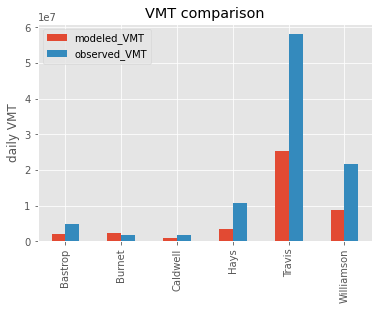

In [12]:
VMT_comparison.plot.bar(x = 'county')
plt.xlabel('')
plt.ylabel('daily VMT')
plt.title('VMT comparison by county')

In [17]:
# assign roadway classification to modeled network, 
# ref: https://wiki.openstreetmap.org/wiki/User:UltimateRiff/HFCS
modeled_roadtype = model_vmt_24_hour.attributeOrigType.unique()
modeled_roadtype_lookup = {'tertiary': 'Minor collector',
                           'trunk_link': 'Freeway and major arterial',
                           'residential': 'Local',
                           'track': 'Local',
                           'footway': 'Local',
                           'motorway': 'Freeway and major arterial',
                           'secondary': 'Major collector',
                           'unclassified': 'Local',
                           'path': 'Local',
                           'secondary_link': 'Major collector',
                           'primary': 'Minor arterial',
                           'motorway_link': 'Freeway and major arterial',
                           'primary_link': 'Minor arterial',
                           'trunk': 'Freeway and major arterial',
                           'pedestrian': 'Local',
                           'tertiary_link': 'Minor collector',
                           'cycleway': 'Local',
                           np.nan: 'Local',
                           'steps': 'Local',
                           'living_street': 'Local', 
                           'bus_stop': 'Local',
                           'corridor': 'Local', 
                           'road': 'Local',
                           'bridleway': 'Local'}

observed_roadtype_lookup = {1: 'Freeway and major arterial',
                            2: 'Freeway and major arterial',
                            3: 'Freeway and major arterial',
                            4: 'Minor arterial',
                            5: 'Major collector',
                            6: 'Minor collector',
                            7: 'Local'}
model_vmt_24_hour.loc[:, 'road_class'] = model_vmt_24_hour.loc[:, 'attributeOrigType'].map(modeled_roadtype_lookup)
observed_vmt.loc[:, 'road_class'] = observed_vmt.loc[:, 'F_SYSTEM'].map(observed_roadtype_lookup)
# print(modeled_roadtype)

In [19]:
model_vmt_by_roadtype = model_vmt_24_hour.groupby(['road_class'])[['VMT']].sum()
model_vmt_by_roadtype = model_vmt_by_roadtype.reset_index()
observed_vmt_by_roadtype = observed_vmt.groupby(['road_class'])[['PVMT']].sum()
observed_vmt_by_roadtype = observed_vmt_by_roadtype.reset_index()
VMT_comparison_by_roadtype = pd.merge(model_vmt_by_roadtype, observed_vmt_by_roadtype, 
                          on = 'road_class', how = 'left')
# VMT_comparison = VMT_comparison.loc[:, ['name', 'VMT', 'PVMT']]
VMT_comparison_by_roadtype.columns = ['road_class', 'modeled_VMT', 'observed_VMT']
VMT_comparison_by_roadtype

,road_class,modeled_VMT,observed_VMT
0,Freeway and major arterial,1.829164e+07,7.671719e+07
1,Local,5.240757e+06,3.603360e+06
2,Major collector,9.420881e+06,1.012683e+07
3,Minor arterial,6.182014e+06,7.713755e+06
4,Minor collector,3.403240e+06,7.158526e+05


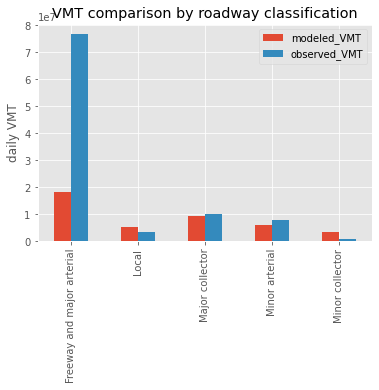

In [20]:
VMT_comparison_by_roadtype.plot.bar(x = 'road_class')
plt.xlabel('')
plt.ylabel('daily VMT')
plt.title('VMT comparison by roadway classification')
plt.savefig('plot/austin_VMT_comparison_by_roadway_type.png', dpi = 200)
plt.show()

/var/folders/w6/7qcyt43n21ddydhdfdslrp7c0000gp/T/ipykernel_1200/1474550622.py:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['{:.0f}%'.format(x*100) for x in ax.get_yticks()])


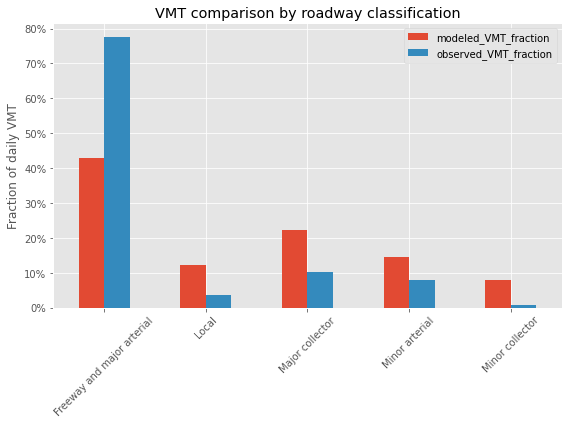

In [35]:
VMT_comparison_by_roadtype.loc[:, 'modeled_VMT_fraction'] = VMT_comparison_by_roadtype.loc[:, 'modeled_VMT'] / VMT_comparison_by_roadtype.loc[:, 'modeled_VMT'].sum()
VMT_comparison_by_roadtype.loc[:, 'observed_VMT_fraction'] = VMT_comparison_by_roadtype.loc[:, 'observed_VMT'] / VMT_comparison_by_roadtype.loc[:, 'observed_VMT'].sum()
percent_VMT_comparison_by_roadtype = VMT_comparison_by_roadtype.loc[:, ['road_class', 'modeled_VMT_fraction', 'observed_VMT_fraction']]

import matplotlib.ticker as mtick
# plt.figure(figsize = (12,8))
ax = percent_VMT_comparison_by_roadtype.plot.bar(x = 'road_class',figsize = (8,6))
# ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%0.1f'))
plt.xlabel('')
plt.xticks(rotation = 45)
ax.set_yticklabels(['{:.0f}%'.format(x*100) for x in ax.get_yticks()]) 
# vals = ax.get_yticks()
# ax.set_yticklabels(['{:,.2%}'.format(x) for x in vals])
plt.ylabel('Fraction of daily VMT')
plt.title('VMT comparison by roadway classification')
plt.tight_layout()
plt.savefig('plot/austin_percent_VMT_comparison_by_roadway_type.png', dpi = 200)
plt.show()

<AxesSubplot:xlabel='attributeOrigType'>

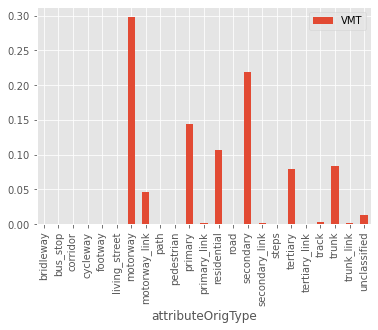

In [37]:
model_vmt_by_osmtype = model_vmt_24_hour.groupby(['attributeOrigType'])[['VMT']].sum()
model_vmt_by_osmtype.loc[:, 'VMT'] /= model_vmt_by_osmtype.loc[:, 'VMT'].sum()
model_vmt_by_osmtype.plot.bar()